# REDES NEURONALES RECURRENTES (RNN) EN FINANZAS

In [ ]:
!pip install yfinance --upgrade --no-cache-dir
!pip install ta

In [2]:
import numpy as np
import pandas as pd
import warnings
import yfinance as yf
import ta
warnings.filterwarnings("ignore")

In [3]:
# El código aquí nos permitirá cambiar los gráficos a modo oscuro
import matplotlib.pyplot as plt

import matplotlib as mpl
from matplotlib import cycler
colors = cycler('color',
                ['#669FEE', '#66EE91', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('figure', facecolor='#313233')
plt.rc('axes', facecolor="#313233", edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors,
       labelcolor='gray')
plt.rc('grid', color='474A4A', linestyle='solid')
plt.rc('xtick', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('legend', facecolor="#313233", edgecolor="#313233")
plt.rc("text", color="#C9C9C9")

# Selección de características

In [4]:
def feature_engineering(df):
    """ Crear nuevas variables """

    # Copiamos el data frame para evitar interferencias entre las variables
    df_copy = df.copy()

    # Creamos la variable de retorno
    df_copy["returns"] = df_copy["close"].pct_change(1)
    df_copy["dummy"] = np.round(df_copy["returns"]+0.5)

    # Creamos las SMAs
    df_copy["SMA 15"] = df_copy[["close"]].rolling(15).mean().shift(1)
    df_copy["SMA 60"] = df_copy[["close"]].rolling(60).mean().shift(1)

    # Creamos las volatilidades
    df_copy["MSD 10"] = df_copy[["returns"]].rolling(10).std().shift(1)
    df_copy["MSD 30"] = df_copy[["returns"]].rolling(30).std().shift(1)

    # Creamos el RSI
    RSI = ta.momentum.RSIIndicator(df_copy["close"], window= 14, fillna = False)
    df_copy["rsi"] = RSI.rsi().shift(1)

    return df_copy.dropna()

# Preparación de los datos

In [8]:
def preprocessing_yf(symbol):

  #Importar los datos
  df = yf.download(symbol,auto_adjust=False).dropna()

  #Renombrar
  df.columns = ["open", "high", "low", "close", "adj close", "volume"]
  df.index.name = "time"

  #Eliminar la columna de cierre ajustado
  del df["adj close"]

  return df

In [9]:
df = preprocessing_yf("BTC-USD")
dfc = feature_engineering(df)
dfc

[*********************100%***********************]  1 of 1 completed


,open,high,low,close,volume,returns,dummy,SMA 15,SMA 60,MSD 10,MSD 30,rsi
time,,,,,,,,,,,,
2014-11-16,387.881989,387.881989,390.799011,374.601990,11905600,0.009687,1.0,349.048798,363.512216,0.036793,0.029844,55.656642
2014-11-17,387.407990,387.407990,410.199005,377.502014,41518800,0.007742,1.0,352.618597,362.215216,0.036582,0.029875,56.952570
2014-11-18,375.197998,375.197998,392.402008,371.117004,32222500,-0.016914,0.0,356.410331,361.621849,0.036594,0.029857,58.018716
2014-11-19,380.554993,380.554993,386.480988,373.895996,18931800,0.007488,1.0,359.452732,361.398266,0.037544,0.029784,54.800616
2014-11-20,357.839996,357.839996,382.024994,356.781006,25233200,-0.045775,0.0,362.707332,361.131816,0.037536,0.029569,55.945938
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-06,96802.476562,96802.476562,96889.179688,93399.859375,26551275827,-0.001778,0.0,92673.794792,84595.840885,0.012747,0.023857,62.493509
2025-05-07,97032.320312,97032.320312,97625.804688,95829.335938,76983822462,0.026012,1.0,93224.196354,84740.543880,0.012232,0.020092,61.830899
2025-05-08,103241.460938,103241.460938,103969.539062,96913.875000,69895404397,0.011317,1.0,93807.183333,84916.908073,0.014761,0.018819,67.284730


In [10]:
dfc.columns

Index(['open', 'high', 'low', 'close', 'volume', 'returns', 'dummy', 'SMA 15',
       'SMA 60', 'MSD 10', 'MSD 30', 'rsi'],
      dtype='object')

In [11]:
# Porcentaje del conjunto de entrenamiento
split = int(0.85*len(dfc))


# Creación del conjunto de entrenamiento
X_train = dfc[["SMA 15", "SMA 60", "MSD 10", "MSD 30", "rsi"]].iloc[:split,:]
y_train = dfc[["dummy"]].iloc[:split,:]


# Creación del conjunto de testing
X_test = dfc[["SMA 15", "SMA 60", "MSD 10", "MSD 30", "rsi"]].iloc[split:,:]
y_test = dfc[["dummy"]].iloc[split:,:]

In [12]:
# ESTANDARIZACIÓN
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

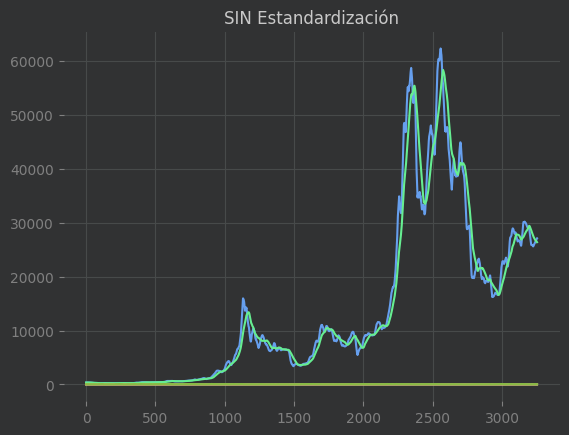

In [13]:
plt.plot(X_train.values)
plt.title("SIN Estandardización")
plt.show()

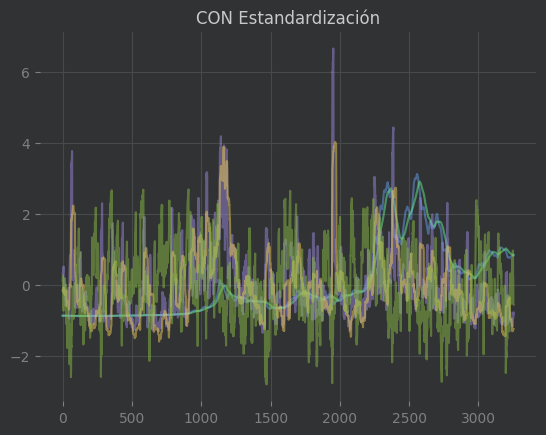

In [14]:
plt.plot(X_train_sc, alpha=0.5)
plt.title("CON Estandardización")
plt.show()

# Transformar arrays 2-dimensionales en arrays de datos 3-dimensionales

In [15]:
def X_3d_RNN(X_s, y_s, lag):

    # Verificación simple de longitudes
    if len(X_s) != len(y_s):
        print("Warnings")

    # Creamos la variable X_train
    X_train = []
    for variable in range(0, X_s.shape[1]):
        X = []
        for i in range(lag, X_s.shape[0]):
            X.append(X_s[i-lag:i, variable])
        X_train.append(X)
    X_train, np.array(X_train)
    X_train = np.swapaxes(np.swapaxes(X_train, 0, 1), 1, 2)

    # Creamos la variable y_train
    y_train = []
    for i in range(lag, y_s.shape[0]):
        y_train.append(y_s[i, :].reshape(-1,1).transpose())
    y_train = np.concatenate(y_train, axis=0)
    return X_train, y_train

In [16]:
lag = 15
X_train_3d, y_train_3d = X_3d_RNN(X_train_sc, y_train.values, lag)
X_test_3d, y_test_3d = X_3d_RNN(X_test_sc, y_test.values, lag)

In [17]:
pd.DataFrame(X_train_3d[0])

,0,1,2,3,4
0,-0.870374,-0.866791,0.314763,-0.158517,0.107791
1,-0.870144,-0.866876,0.304575,-0.156713,0.193062
2,-0.869899,-0.866914,0.305168,-0.157729,0.263213
3,-0.869703,-0.866929,0.351125,-0.162046,0.051465
4,-0.869493,-0.866946,0.350733,-0.174669,0.126826
5,-0.869381,-0.866986,0.447937,-0.108666,-0.402826
6,-0.869356,-0.867043,0.497192,-0.073927,-0.727106
7,-0.869317,-0.867093,0.518316,-0.204928,-0.517434
8,-0.869270,-0.867166,-0.248455,-0.206291,-0.446509
9,-0.869173,-0.867213,-0.133151,-0.192972,-0.056212


In [18]:
y_train_3d[0]

array([1.])

In [19]:
np.shape(X_train_3d)

(3239, 15, 5)

# Red Neuronal Recurrente

In [20]:
from tensorflow.keras.callbacks import EarlyStopping

# Librerías
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

nb_hidden_layer = 3


# Inicialización del modelo
classifier = Sequential()

# Añadimos la capa LSTM
classifier.add(LSTM(units = 10, return_sequences = True,
                    input_shape = (X_train_3d.shape[1],X_train_3d.shape[2],)))


# Bucle para añadir capas LSTM
for _ in range(nb_hidden_layer):
    classifier.add(LSTM(units = 10, return_sequences = True))
    classifier.add(Dropout(0.15))

# Última capa LSTM con el parámetro return_sequences = False
classifier.add(LSTM(units = 10, return_sequences = False))


# Capa Densa de Salida
classifier.add(Dense(1, activation="sigmoid"))

# Compilamos el modelo
classifier.compile(loss="binary_crossentropy", optimizer="adam")


# Entrenamiento y la parada temprana
early_stop = EarlyStopping(verbose=1, patience = 5)

classifier.fit(X_train_3d, y_train_3d, validation_data=(X_test_3d, y_test_3d), epochs=100, callbacks=[early_stop])

Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - loss: 0.6830 - val_loss: 0.6877
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.6795 - val_loss: 0.6912
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.6765 - val_loss: 0.6859
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.6802 - val_loss: 0.6858
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.6735 - val_loss: 0.6879
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.6744 - val_loss: 0.6915
Epoch 7/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.6761 - val_loss: 0.6907
Epoch 8/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.6799 - val_loss: 0.6980
Epoch 9/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.6768 - val_loss: 0.7035
Epoch 9: early stopping


<Axes: >

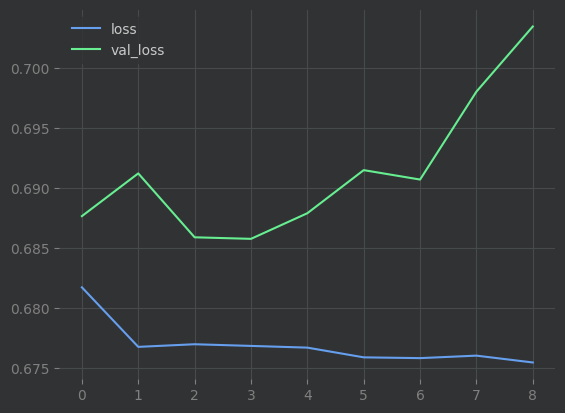

In [21]:
pd.DataFrame(classifier.history.history).plot()

In [22]:
# Predicciones para el dataset completo
y_pred_train = np.concatenate((np.zeros([lag,1]),classifier.predict(X_train_3d)),
                                    axis=0)

y_pred_test = np.concatenate((np.zeros([lag,1]),classifier.predict(X_test_3d)),
                                    axis=0)


dfc["prediction"] = np.concatenate((y_pred_train,y_pred_test),
                                    axis=0)

dfc["prediction"] = np.where(dfc["prediction"] < 0.5, -1,1)

# Cálculo de la estrategia
dfc["strategy"] =  dfc["prediction"].shift(1) * dfc["returns"]

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [23]:
print(f"X_train_3d: {np.shape(y_pred_train)}")
print(f"X_test_3d: {np.shape(y_pred_test)}")
print(f"X: {np.shape(dfc)}")

X_train_3d: (3254, 1)
X_test_3d: (575, 1)
X: (3829, 14)


In [24]:
2477+438

2915

<Axes: xlabel='time'>

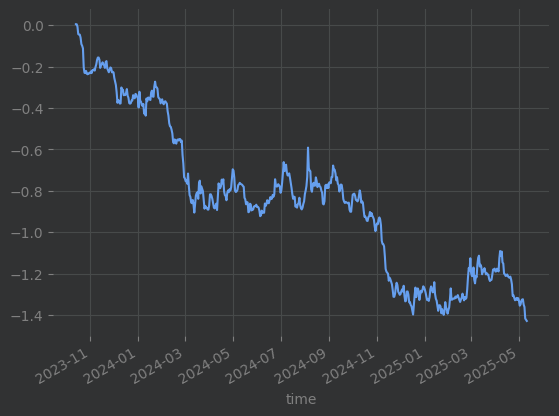

In [25]:
dfc["strategy"].iloc[split:].cumsum().plot()

In [38]:
import os

# Automatización

In [39]:
def feature_engineering(df):
    """ Creamos nuevas variables"""

    #
    df_copy = df.copy()

    # returns
    df_copy["returns"] = df_copy["close"].pct_change(1)
    df_copy["dummy"] = np.round(df_copy["returns"]+0.5)

    #  SMAs
    df_copy["SMA 15"] = df_copy[["close"]].rolling(15).mean().shift(1)
    df_copy["SMA 60"] = df_copy[["close"]].rolling(60).mean().shift(1)

    # Volatilidades
    df_copy["MSD 10"] = df_copy[["returns"]].rolling(10).std().shift(1)
    df_copy["MSD 30"] = df_copy[["returns"]].rolling(30).std().shift(1)

    # RSI
    RSI = ta.momentum.RSIIndicator(df_copy["close"], window= 14, fillna = False)
    df_copy["rsi"] = RSI.rsi().shift(1)

    return df_copy.dropna()

def preprocessing_yf(symbol):

  #
  df = yf.download(symbol,auto_adjust=False).dropna()

  #Renombramos
  df.columns = ["open", "high", "low", "close", "adj close", "volume"]
  df.index.name = "time"

  # Removemos adj close
  del df["adj close"]

  return df


def X_3d_RNN(X_s, y_s, lag):

    # Verificación Simple
    if len(X_s) != len(y_s):
        print("Warnings")

    #  X_train
    X_train = []
    for variable in range(0, X_s.shape[1]):
        X = []
        for i in range(lag, X_s.shape[0]):
            X.append(X_s[i-lag:i, variable])
        X_train.append(X)
    X_train, np.array(X_train)
    X_train = np.swapaxes(np.swapaxes(X_train, 0, 1), 1, 2)

    #  y_train
    y_train = []
    for i in range(lag, y_s.shape[0]):
        y_train.append(y_s[i, :].reshape(-1,1).transpose())
    y_train = np.concatenate(y_train, axis=0)
    return X_train, y_train


import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

def RNN(symbol, nb_neurons=10, nb_hidden_layer=1, lag=15, nb_model=None):

  df = yf.download(symbol,auto_adjust=False)[["Open", "High", "Low", "Adj Close", "Volume"]]
  df.columns = ["open", "high", "low", "close", "volume"]
  dfc = feature_engineering(df)


  # Percentage train set
  split = int(0.80*len(dfc))
  split_val = int(0.90*len(dfc))

  # Train set creation
  X_train = dfc[['SMA 15', 'SMA 60',
        'MSD 10', 'MSD 30', 'rsi']].iloc[:split,:]
  y_train = dfc[["dummy"]].iloc[:split]


  # Test set creation
  X_test = dfc[['SMA 15', 'SMA 60',
        'MSD 10', 'MSD 30', 'rsi']].iloc[split:,:]
  y_test = dfc[["dummy"]].iloc[split:]

  # Estandarización
  from sklearn.preprocessing import StandardScaler

  sc = StandardScaler()

  X_train_sc = sc.fit_transform(X_train)
  X_test_sc = sc.transform(X_test)

  # Transform 2-dimensional data a una 3-dimensional
  X_train_3d, y_train_3d = X_3d_RNN(X_train_sc, y_train.values, lag)
  X_test_3d, y_test_3d = X_3d_RNN(X_test_sc, y_test.values, lag)

  # NICIALIZANDI EL MODELO
  classifier = Sequential()

  # Añadimos LSTM LAYER
  classifier.add(LSTM(units = nb_neurons, return_sequences = True,
                      input_shape = (X_train_3d.shape[1],X_train_3d.shape[2],)))


  # LOOP WHICH  LSTM LAYER
  for _ in range(nb_hidden_layer):
      classifier.add(LSTM(units = nb_neurons, return_sequences = True))
      classifier.add(Dropout(0.20))

  # LAST LSTM LAYER BUT WITH return_sequences = False
  classifier.add(LSTM(units = nb_neurons, return_sequences = False))


  # OUTPUT DENSE LAYER
  classifier.add(Dense(1, activation="sigmoid"))

  # compilando
  classifier.compile(loss="binary_crossentropy", optimizer="adam")


  # Entrenando
  early_stop = EarlyStopping(verbose=1, patience = 5)
  classifier.fit(X_train_3d, y_train_3d, validation_data=(X_test_3d, y_test_3d),
                 epochs=1, callbacks=[early_stop])

  # Predicciones para el modelo completo
  y_pred_train = np.concatenate((np.zeros([lag,1]),classifier.predict(X_train_3d)),
                                      axis=0)

  y_pred_test = np.concatenate((np.zeros([lag,1]),classifier.predict(X_test_3d)),
                                      axis=0)

  dfc["prediction"] = np.concatenate((y_pred_train,y_pred_test),
                                      axis=0)

  dfc["prediction"] = np.where(dfc["prediction"] < 0.5, -1,1)

  # Estrategia
  dfc["strategy"] = np.sign(dfc["prediction"]) * dfc["returns"]

  if nb_model is not None:
        #
        os.makedirs("Weights_RNN", exist_ok=True)
        classifier.save_weights(f"Weights_RNN/RNN n°{nb_model}.weights.h5")
        return dfc["strategy"].iloc[split+lag:split_val], dfc["strategy"].iloc[split_val:]
  else:
        return dfc["strategy"].iloc[split+lag:split_val], dfc["strategy"].iloc[split_val:]

In [40]:
sr = RNN("BTC-USD", nb_model=15)

sr

[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.6886 - val_loss: 0.6930
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


(Date
 2023-04-21   -0.034309
 2023-04-22    0.019819
 2023-04-23   -0.008129
 2023-04-24   -0.002394
 2023-04-25    0.028420
                 ...   
 2024-04-18    0.036491
 2024-04-19    0.005209
 2024-04-20    0.018026
 2024-04-21   -0.001043
 2024-04-22    0.029434
 Name: strategy, Length: 368, dtype: float64,
 Date
 2024-04-23   -0.006440
 2024-04-24   -0.032080
 2024-04-25    0.003186
 2024-04-26    0.011265
 2024-04-27    0.005273
                 ...   
 2025-05-06    0.021683
 2025-05-07    0.002374
 2025-05-08    0.063990
 2025-05-09   -0.002621
 2025-05-11    0.011186
 Name: strategy, Length: 383, dtype: float64)

In [41]:
# Librería requerida
from tqdm import tqdm

# Retornos
returns_test = []
returns_val = []


# Cacula los retornos durante la validación de test
for i in tqdm(range(100)):
  test, val = RNN("BTC-USD", nb_model=i)
  returns_test.append(test)
  returns_val.append(val)

[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.6926 - val_loss: 0.6940
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.6905 - val_loss: 0.6939
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 0.6933 - val_loss: 0.6937
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.6908 - val_loss: 0.6938
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 0.6943 - val_loss: 0.6944
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - loss: 0.6933 - val_loss: 0.6936
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.6949 - val_loss: 0.6927
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 0.6890 - val_loss: 0.6934
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.6925 - val_loss: 0.6935
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.6918 - val_loss: 0.6933
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.6914 - val_loss: 0.6945
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.6951 - val_loss: 0.6934
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.6896 - val_loss: 0.6942
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.6909 - val_loss: 0.6939
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 0.6945 - val_loss: 0.6943
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.6936 - val_loss: 0.6935
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.6970 - val_loss: 0.6953
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.6894 - val_loss: 0.6939
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.6917 - val_loss: 0.6936
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.6932 - val_loss: 0.6937
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 0.6892 - val_loss: 0.6941
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.6920 - val_loss: 0.6935
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.6934 - val_loss: 0.6928
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - loss: 0.6926 - val_loss: 0.6942
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.6931 - val_loss: 0.6962
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - loss: 0.6940 - val_loss: 0.6941
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - loss: 0.6949 - val_loss: 0.6946
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - loss: 0.6927 - val_loss: 0.6941
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.6914 - val_loss: 0.6938
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.6943 - val_loss: 0.6953
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 0.6933 - val_loss: 0.6940
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.6927 - val_loss: 0.6937
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 0.6946 - val_loss: 0.6931
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.6927 - val_loss: 0.6931
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 0.6953 - val_loss: 0.6942
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - loss: 0.6910 - val_loss: 0.6937
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - loss: 0.6936 - val_loss: 0.6954
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 0.6937 - val_loss: 0.6943
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.6904 - val_loss: 0.6943
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.6906 - val_loss: 0.6957
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.6930 - val_loss: 0.6943
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - loss: 0.6904 - val_loss: 0.6938
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.6916 - val_loss: 0.6939
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.6932 - val_loss: 0.6953
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - loss: 0.6908 - val_loss: 0.6937
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - loss: 0.6920 - val_loss: 0.6960
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - loss: 0.6933 - val_loss: 0.6954
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.6933 - val_loss: 0.6929
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.6918 - val_loss: 0.6940
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - loss: 0.6926 - val_loss: 0.6936
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - loss: 0.6953 - val_loss: 0.6935
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - loss: 0.6924 - val_loss: 0.6932
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - loss: 0.6913 - val_loss: 0.6932
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 14s 51ms/step - loss: 0.6928 - val_loss: 0.6928
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.6923 - val_loss: 0.6929
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - loss: 0.6922 - val_loss: 0.6940
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 0.6985 - val_loss: 0.6948
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - loss: 0.6956 - val_loss: 0.6928
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.6919 - val_loss: 0.6937
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.6944 - val_loss: 0.6934
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.6937 - val_loss: 0.6932
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - loss: 0.6943 - val_loss: 0.6946
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.6934 - val_loss: 0.6950
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 0.6914 - val_loss: 0.6935
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.6933 - val_loss: 0.6944
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.6926 - val_loss: 0.6945
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.6938 - val_loss: 0.6931
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.6908 - val_loss: 0.6937
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 0.6942 - val_loss: 0.6941
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 0.6918 - val_loss: 0.6933
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 0.6942 - val_loss: 0.6946
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.6925 - val_loss: 0.6932
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.6942 - val_loss: 0.6932
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 0.6881 - val_loss: 0.6937
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.6901 - val_loss: 0.6928
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 0.6905 - val_loss: 0.6944
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.6909 - val_loss: 0.6936
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.6901 - val_loss: 0.6939
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.6908 - val_loss: 0.6936
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.6924 - val_loss: 0.6934
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.6905 - val_loss: 0.6941
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.6939 - val_loss: 0.6940
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.6901 - val_loss: 0.6933
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - loss: 0.6938 - val_loss: 0.6945
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - loss: 0.6892 - val_loss: 0.6939
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.6914 - val_loss: 0.6937
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.6920 - val_loss: 0.6947
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.6938 - val_loss: 0.6953
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 0.6923 - val_loss: 0.6932
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.6920 - val_loss: 0.6953
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.6890 - val_loss: 0.6942
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.6928 - val_loss: 0.6934
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.6882 - val_loss: 0.6933
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.6934 - val_loss: 0.6957
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.6926 - val_loss: 0.6937
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.6909 - val_loss: 0.6944
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.6946 - val_loss: 0.6926
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.6921 - val_loss: 0.6938
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.6923 - val_loss: 0.6938
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[*********************100%***********************]  1 of 1 completed


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.6922 - val_loss: 0.6939
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


100%|██████████| 100/100 [21:25<00:00, 12.86s/it]


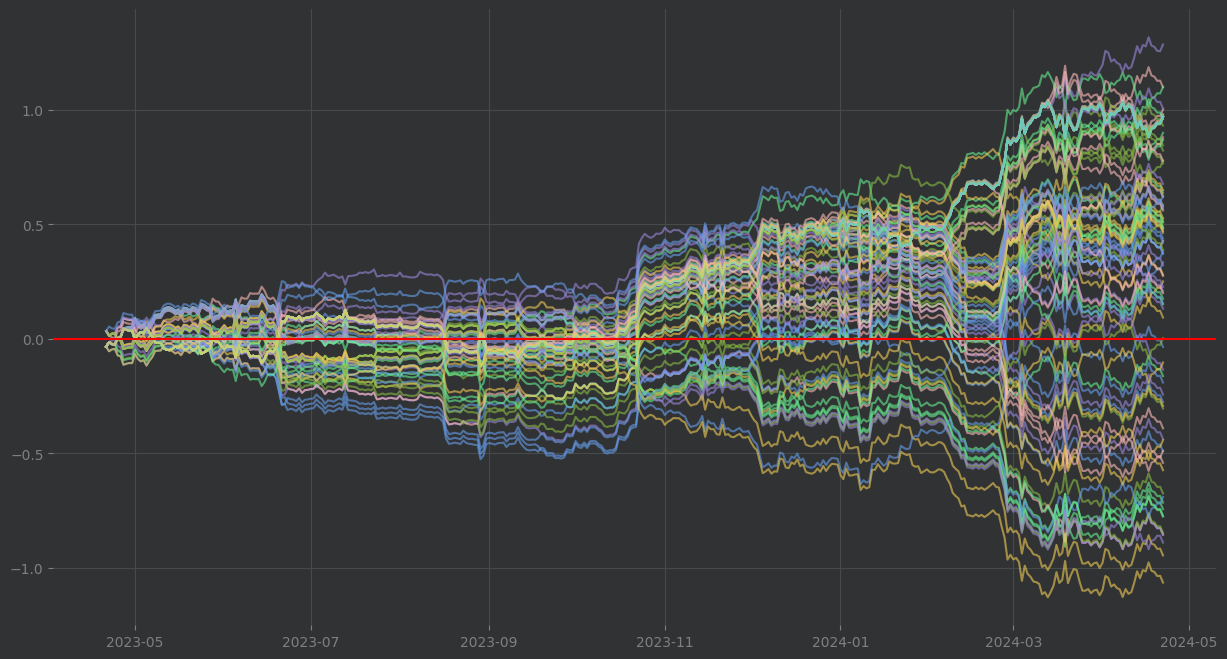

In [42]:
""" No es una simulación Monte Carlo """

# Organizamos bien todos los datos
RNN_returns = pd.DataFrame(returns_test, index=[f"RNN n°{i}" for i in range(len(returns_test))]).transpose()

#
plt.figure(figsize=(15,8))

#Retornos
plt.plot(RNN_returns.cumsum(axis=0), alpha=0.6)

# Break-even
plt.axhline(0, color="red")

#
plt.show()

# Crear un criterio

In [43]:
def drawdown_function(serie):

  # Retornos
  cum = serie.dropna().cumsum() + 1

  # (accumulate max) # (1,3,5,3,1) --> (1,3,5,5,5)
  running_max = np.maximum.accumulate(cum)

  #  drawdown
  drawdown = cum/running_max - 1
  return drawdown

In [44]:
#
values = pd.DataFrame(index=["ret/dd", "ret", "dd"])

# Cálculo de retorno y max drawdawn para cada  ANN
for col in RNN_returns.columns:

  # Cálculo de retorno y max drawdawn para una ANN
  ret, dd = RNN_returns[col].cumsum().iloc[-1], -np.min(drawdown_function(RNN_returns[col]))

  #
  values[col] = ret/dd, ret, dd

In [45]:
values.transpose().sort_values(by="ret/dd", ascending=False)

,ret/dd,ret,dd
RNN n°26,6.737503,1.285817,0.190845
RNN n°25,6.675672,1.101192,0.164956
RNN n°23,5.755863,1.098476,0.190845
RNN n°9,5.358436,0.979217,0.182743
RNN n°56,5.271511,1.006040,0.190845
...,...,...,...
RNN n°70,-0.921005,-0.847221,0.919888
RNN n°38,-0.924516,-0.855962,0.925849
RNN n°45,-0.937289,-0.945511,1.008772
RNN n°93,-0.946986,-1.064292,1.123873


In [46]:
RNN_models = list(values.transpose().sort_values(by="ret/dd", ascending=False).index[0:3])

In [47]:
RNN_models

['RNN n°26', 'RNN n°25', 'RNN n°23']

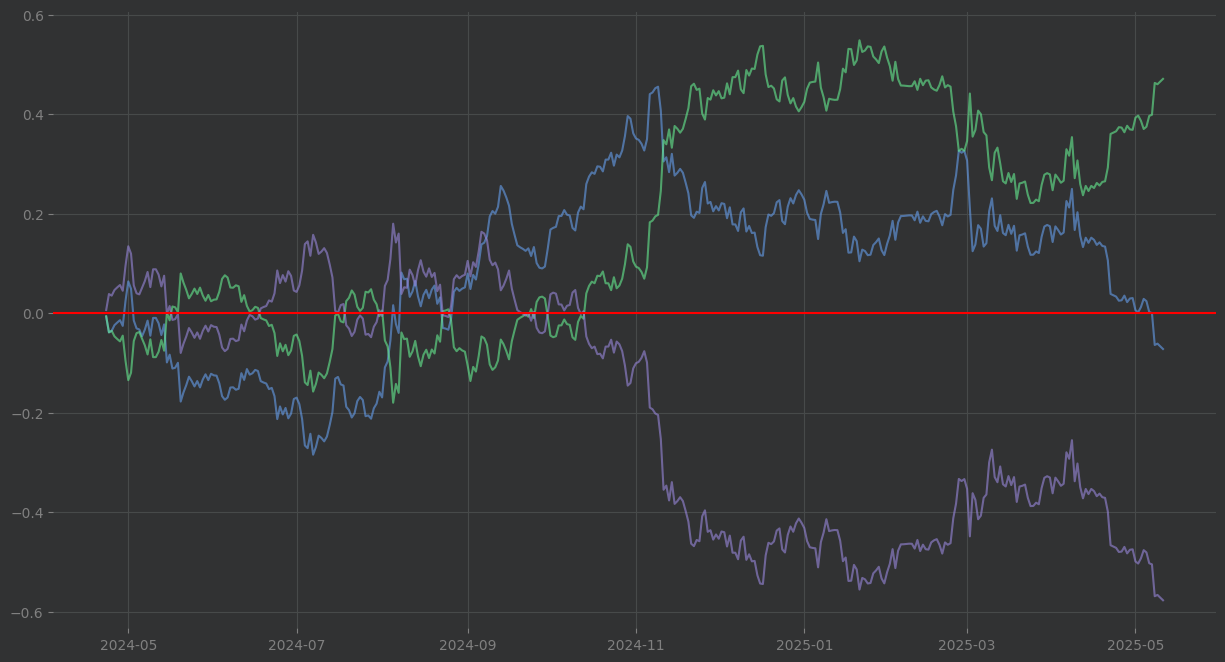

In [48]:

""" Usa el 3best sobre el conjunto de trade en el set de validación """
#
RNN_val = pd.DataFrame(returns_val, index=[f"RNN n°{i}" for i in range(len(returns_val))]).transpose()

#
plt.figure(figsize=(15,8))

# Plotea el portafolio con las 10 mejores estrategias
plt.plot(RNN_val[RNN_models].cumsum(axis=0), alpha=0.6)

plt.axhline(0, color="red")

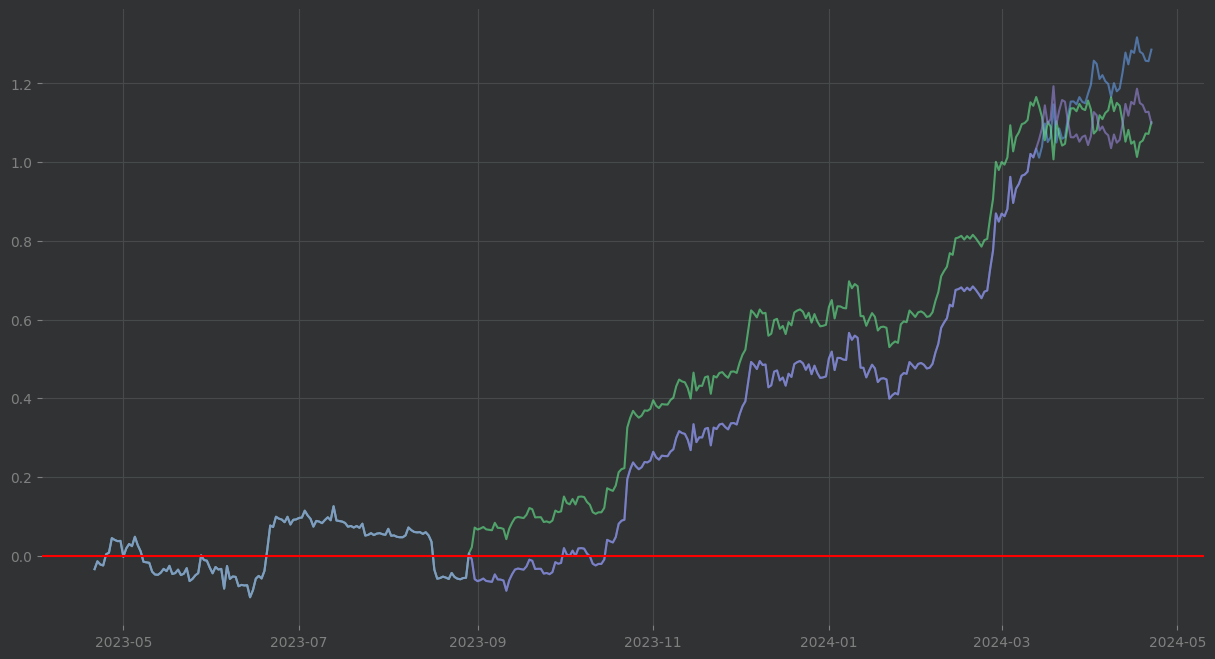

In [49]:
"""  Usa el 3best sobre el conjunto de trade en el set de test"""

#
RNN_val = pd.DataFrame(returns_val, index=[f"RNN n°{i}" for i in range(len(returns_val))]).transpose()

#
plt.figure(figsize=(15,8))

#
plt.plot(RNN_returns[RNN_models].cumsum(axis=0), alpha=0.6)

plt.axhline(0, color="red")

# Técnicas de bagging

In [50]:
def RNN_weights():
  # Inicialización del modelo
  classifier = Sequential()

  # LSTM
  classifier.add(LSTM(units = 10, return_sequences = True,
                      input_shape = (X_train_3d.shape[1],X_train_3d.shape[2],)))


  # LOOP WHICH ADD LSTM LAYER
  for _ in range(1):
      classifier.add(LSTM(units = 10, return_sequences = True))
      classifier.add(Dropout(0.50))

  # LAST LSTM LAYER BUT WITH return_sequences = False
  classifier.add(LSTM(units = 10, return_sequences = False))


  # OUTPUT DENSE LAYER
  classifier.add(Dense(1, activation="sigmoid"))

  # COMPILANDO EL MODELO
  classifier.compile(loss="binary_crossentropy", optimizer="adam")

  return classifier

In [53]:
#
prediction = pd.DataFrame(index = dfc.index)
for nb in RNN_models:

  # Estructura RNN
  rnn = RNN_weights()

  # Pesos
  rnn.load_weights(f"Weights_RNN/{nb}.weights.h5")

  #

  y_pred_train = np.concatenate((np.zeros([lag,1]),rnn.predict(X_train_3d)),
                                    axis=0)

  y_pred_test = np.concatenate((np.zeros([lag,1]),rnn.predict(X_test_3d)),
                                    axis=0)


  pre = np.concatenate((y_pred_train,y_pred_test),
                                    axis=0)

  prediction[f"{nb}"] = pre
prediction

102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


,RNN n°26,RNN n°25,RNN n°23
time,,,
2014-11-16,0.000000,0.000000,0.000000
2014-11-17,0.000000,0.000000,0.000000
2014-11-18,0.000000,0.000000,0.000000
2014-11-19,0.000000,0.000000,0.000000
2014-11-20,0.000000,0.000000,0.000000
...,...,...,...
2025-05-06,0.483609,0.511213,0.490300
2025-05-07,0.484443,0.510883,0.490373
2025-05-08,0.485451,0.510614,0.490488


In [54]:
prediction["Increase"] = (np.sign(prediction[RNN_models]-0.5)==1).sum(axis=1)
prediction["Decrease"] = (np.sign(prediction[RNN_models]-0.5)==-1).sum(axis=1)

In [55]:
# Delete the rows containing only some 0
prediction = prediction.iloc[lag:,:]
prediction

,RNN n°26,RNN n°25,RNN n°23,Increase,Decrease
time,,,,,
2014-12-01,0.543476,0.541467,0.528399,3,0
2014-12-02,0.543732,0.541662,0.527247,3,0
2014-12-03,0.543966,0.541989,0.525920,3,0
2014-12-04,0.544190,0.542483,0.524508,3,0
2014-12-05,0.544754,0.543478,0.523682,3,0
...,...,...,...,...,...
2025-05-06,0.483609,0.511213,0.490300,1,2
2025-05-07,0.484443,0.510883,0.490373,1,2
2025-05-08,0.485451,0.510614,0.490488,1,2


<Axes: xlabel='time'>

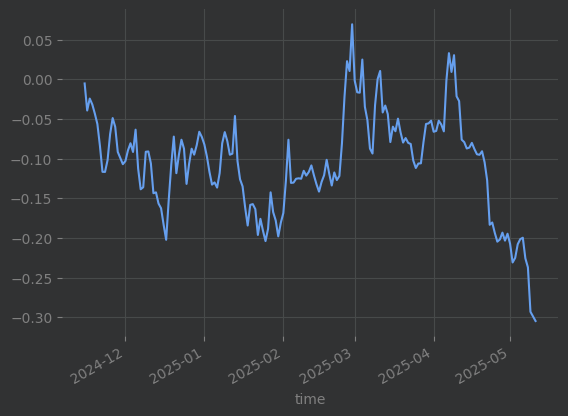

In [56]:
# Put the daily return of the asset
prediction["returns"] = dfc["returns"]

# Compute the position doing a bagging on the best ANN
prediction["position"] = np.nan
prediction.loc[prediction["Increase"] > prediction["Decrease"], "position"] = 1
prediction.loc[prediction["Increase"] < prediction["Decrease"], "position"] = -1

# When you will run again the code you can have different results
# Compute and plot the strategy return on the validation test
# Very important to put the shift at he position,Don't forget!
prediction["strategy"] = prediction["returns"] * prediction["position"].shift(1)
split, split_val = int(0.85*len(dfc)), int(0.95*len(dfc))
prediction["strategy"].iloc[split_val:].cumsum().plot()